In [1]:
%pylab inline
tau = 2.0 * pi

Populating the interactive namespace from numpy and matplotlib


In [2]:
from datetime import timedelta

import ephem
from iso8601 import parse_date

def datestr(s):
    return parse_date(s, default_timezone=None)

tle = """ISS
1 25544U 98067A   18171.89181005  .00001612  00000-0  31509-4 0  9992
2 25544  51.6423   0.2419 0002732 207.8583 302.1867 15.54203750119095
"""

line0, line1, line2 = tle.split('\n')[:3]

In [3]:
sat = ephem.readtle(line0, line1, line2)

gs = ephem.Observer()
# vu = ['Valparaiso University', '41.4639', '-87.0439', 245.089]
gs.name = 'Valparaisio University'
gs.lon = '-87.0439'
gs.lat = '41.4639'
gs.elevation = 245.1
gs.pressure = 0


In [15]:
@np.vectorize
def sat_el(dt):
    """time in seconds"""
    gs.date = start + timedelta(seconds=dt)
    sat.compute(gs)
    sat_el.calls += 1
    return sat.alt*180.0/pi
sat_el.calls = 0

In [16]:
start = datestr('2018-06-20 00:00:00')
minute = timedelta(minutes=1)

In [6]:
# orbital period in seconds
period = 24.0 * 60.0 * 60.0 / float(line2[52:63])

In [89]:
time_est = np.arange(0, 60*60*24*90, period/6)

sat_el.calls = 0
el = np.fromiter((sat_el(dt) for dt in time_est), np.float, time_est.size)
print(len(time_est), sat_el.calls)

8393 16786


In [91]:
from scipy.signal import argrelmax

fast_peak_idx = argrelmax(el)[0]

In [92]:
fast_peak_idx

array([   5,   11,   17, ..., 8379, 8385, 8391])

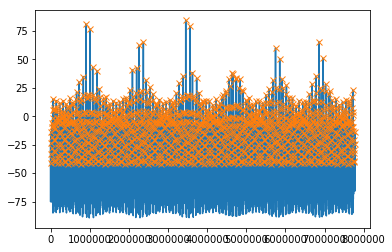

In [93]:
plot(time_est, el, '-')
plot(time_est[fast_peak_idx], el[fast_peak_idx], 'x')

In [94]:
# find true peak around each fast_peak value

from scipy.optimize import minimize_scalar
def fneg(dt):
    return -sat_el(dt)

def truepeak(t, tol=1.0):
    r = minimize_scalar(
            fneg,
            bracket=(t-period/6, t+period/6),
        tol = tol/t,
    )
    return r.x

In [95]:
sat_el.calls = 0

true_peak_times = np.fromiter((truepeak(x) for x in time_est[fast_peak_idx]), np.float)

print(sat_el.calls / fast_peak_idx.size)

25.34857142857143


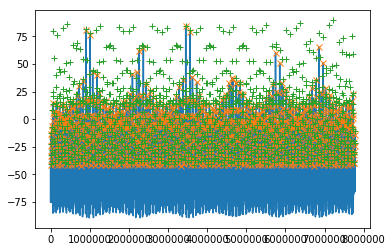

In [96]:
plot(time_est, el, '-')
plot(time_est[fast_peak_idx], el[fast_peak_idx], 'x')

true_el = sat_el(true_peak_times)
plot(true_peak_times, true_el, '+')

In [97]:
def tolspec(tol):
    sat_el.calls = 0
    results = np.fromiter((truepeak(x, tol) for x in time_est[fast_peak_idx]), np.float)
    print(tol, sat_el.calls / fast_peak_idx.size)
    return results

t1, t01, t001, t0001 = [tolspec(tol) for tol in (1.0, 0.1, 0.01, 0.001)]

1.0 25.34857142857143
0.1 29.765714285714285
0.01 36.174285714285716
0.001 39.13857142857143


In [85]:
np.max(np.abs(t1 - t0001))

1.0029784387443215

In [86]:
np.max(np.abs(t01 - t0001))

1.189741331152618

In [87]:
np.max(np.abs(t001 - t0001))

1.1772241471335292